In [1]:
import os
import struct
import numpy as np
import sys
import gzip
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid,train_test_split
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")

### Generate the noisy sin data and plot them 

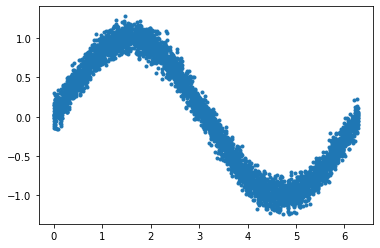

In [191]:
n_samples=5000
x_values=np.random.uniform(low=0,high=2*np.pi,size=n_samples)
sin_wave=np.sin(x_values)+(0.1*np.random.randn(x_values.shape[0]))
plt.plot(x_values,sin_wave,'.')
plt.show()

In [192]:
np.mean((np.sin(x_values)-sin_wave)**2)

0.009841276213353307

### Defining the MLP 

To define the MLP the class MLPRegressor from sklearn has been used (see https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html), the parameter n_iter_no_change has been set equal to the number of epochs to be sure that the training procedure will run till the end. 

In [3]:
class MLP():
    
    def _compute_cost(self, y, output):
        
        squared_weights_sum=0
        weights=np.array(self.mlp.coefs_)
        
        for layer_weights in weights:
            squared_weights_sum+=np.sum(layer_weights**2)
            
        L2_term = (self.l2 * (squared_weights_sum))
        
        cost = np.sum(np.square(output-y))/output.shape[0] + L2_term
        return cost

    
    def __init__(self,n_hidden=100,seed=2,l2 = 0.001,epochs = 80,eta = 0.005,shuffle = True, minibatch_size = 100):
        
        self.n_hidden=n_hidden
        self.seed=seed
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        self.mlp=None
        
    def train(self,X_train,y_train,X_validation,y_validation):
        
        loss_curve_training=[]
        loss_curve_validation=[]
        
        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost': [], 'train_mse': [], 'valid_mse': []}
        
        self.mlp=MLPRegressor(hidden_layer_sizes=self.n_hidden,activation='relu',max_iter=self.epochs,solver='adam',
                                shuffle=self.shuffle,
                                batch_size=self.minibatch_size,learning_rate_init=self.eta,verbose=False,alpha=self.l2,
                                n_iter_no_change=self.epochs)
        
        for i in range(self.epochs):
            
            self.mlp.partial_fit(X_train,y_train)
            y_pred_training=self.predict(X_train)
            y_pred_validation=self.predict(X_validation)
            mse_training=np.mean(np.square(y_train-y_pred_training))
            mse_validation=np.mean(np.square(y_validation-y_pred_validation))
            
            loss_curve_training.append(mse_training)
            loss_curve_validation.append(mse_validation)
            
            cost = self._compute_cost(y=y_train,
                                      output=y_pred_training)
            

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid MSE.: %.2f/%.2f ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              mse_training, mse_validation))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_mse'].append(mse_training)
            self.eval_['valid_mse'].append(mse_validation)
            
        
    def evaluate(self,X,y):
        
        y_pred=self.predict(X)
        mse=np.mean(np.square(y-y_pred))
        print("mean squared error:{}".format(mse))
        
    def predict(self,X):
        
        if(self.mlp==None):
            print("model not trained")
        else:
            predictions=self.mlp.predict(X)
        
        return predictions
    
    def printer(self):
        return self.eval_['train_mse'],self.eval_['valid_mse']
    
    def printer_train(self):
        return self.eval_['cost']
    


In [71]:
import numpy as np
from sklearn.model_selection import train_test_split


X_values = x_values.reshape(-1, 1)
# sin_wave = sin_wave.reshape(-1, 1)


X_train_val, X_test, y_train_val, y_test = train_test_split(X_values, sin_wave, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=(1/3), random_state=42)


mlp = MLP()
mlp.train(X_train, y_train, X_val, y_val)
mlp.evaluate(X_test, y_test)


80/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

mean squared error:0.011486870999282521


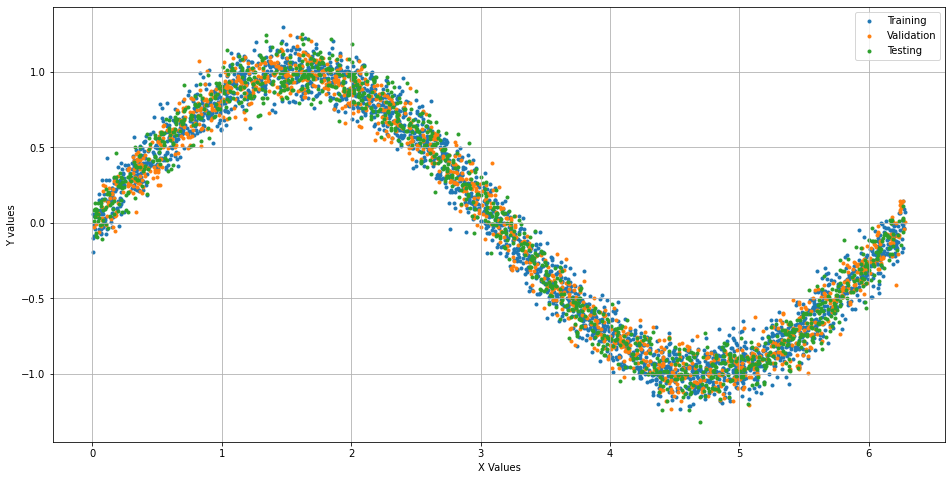

In [150]:
plt.figure(figsize=(16,8))
plt.scatter(X_train, y_train, label='Training', marker='.')
plt.scatter(X_val, y_val, label='Validation', marker='.')
plt.scatter(X_test, y_test, label='Testing', marker='.')
plt.xlabel('X Values')
plt.ylabel('Y values')
plt.grid()
# plt.title('Scatter Plot of X versus sin(X)')
plt.legend()
plt.show()

In [74]:
print('Train data is size: ',np.shape(y_train)[0], 'Test data is size: ', np.shape(y_test)[0],'Validation data is size: ',(np.shape(y_val)[0]))

Train data is size:  2500 Test data is size:  1250 Validation data is size:  1250


In [75]:
mlp.evaluate(X_test, y_test)

mean squared error:0.011486870999282521


In [108]:
msetrain, mseval = mlp.printer()

In [77]:
X_MSE = np.linspace(0,80,80)

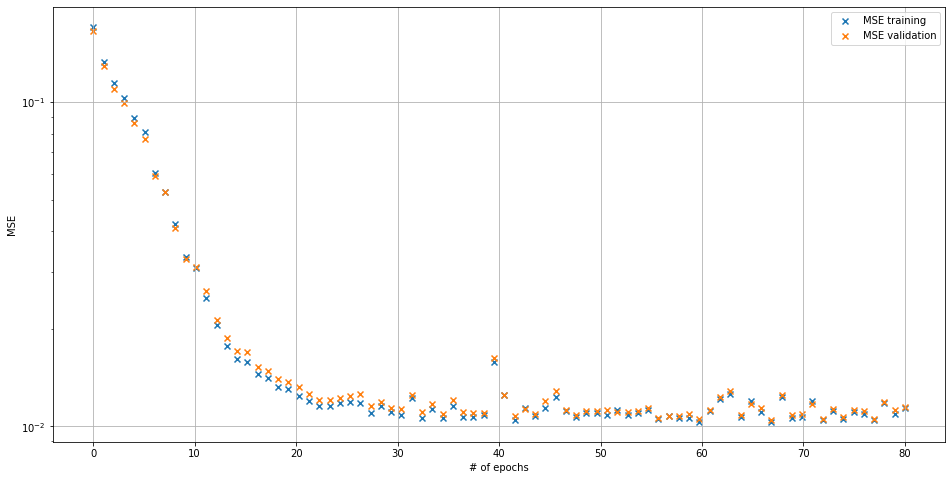

In [113]:
plt.figure(figsize=(16,8))
plt.scatter(X_MSE,msetrain, label='MSE training', marker='x')
plt.scatter(X_MSE,mseval, label='MSE validation', marker='x')
plt.xlabel('# of epochs')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
plt.grid()

The learning rate is a hyperparameter that controls the step size at each iteration during the training process of a machine learning model. It determines how quickly or slowly the model learns from the training data.

In [79]:
eta = 0.005
scalar = np.arange(0.01,50,1)


In [106]:
def opti(scalar):
    mse_optim = []
    mse_train = []
    mse_valid = []
    for idx, val in enumerate(scalar):
        print(val*eta)
        mlp_i = MLP(eta = eta*val)
        mlp_i.train(X_train, y_train, X_val, y_val)
        cost = mlp_i.printer_train()
        mse_training, mse_costing = mlp_i.printer()
        last_cost = cost[-1]
        last_mse_train = mse_training[-1]
        last_mse_valid = mse_costing[-1]
        mse_optim.append(last_cost)
        mse_train.append(last_mse_train)
        mse_valid.append(last_mse_valid)
    return mse_optim, mse_train, mse_valid
    

In [107]:
mse_optim, mse_train, mse_valid = opti(scalar)

08/80 | Cost: 0.38 | Train/Valid MSE.: 0.37/0.37 

5e-05


08/80 | Cost: 0.07 | Train/Valid MSE.: 0.06/0.06 

0.00505


07/80 | Cost: 0.04 | Train/Valid MSE.: 0.03/0.03 

0.01005


08/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.01505


07/80 | Cost: 0.06 | Train/Valid MSE.: 0.05/0.05 

0.02005


07/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.02505


08/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.03005


07/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.03505


08/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.04005


08/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.04505


07/80 | Cost: 0.05 | Train/Valid MSE.: 0.04/0.03 

0.05005


07/80 | Cost: 0.07 | Train/Valid MSE.: 0.06/0.05 

0.05505


08/80 | Cost: 0.07 | Train/Valid MSE.: 0.05/0.05 

0.06005


07/80 | Cost: 0.11 | Train/Valid MSE.: 0.10/0.10 

0.06505


06/80 | Cost: 0.05 | Train/Valid MSE.: 0.03/0.03 

0.07005


06/80 | Cost: 0.11 | Train/Valid MSE.: 0.09/0.09 

0.07505


07/80 | Cost: 0.17 | Train/Valid MSE.: 0.15/0.15 

0.08005000000000001


07/80 | Cost: 0.10 | Train/Valid MSE.: 0.08/0.08 

0.08505000000000001


07/80 | Cost: 0.19 | Train/Valid MSE.: 0.16/0.16 

0.09005


08/80 | Cost: 0.17 | Train/Valid MSE.: 0.15/0.14 

0.09505000000000001


07/80 | Cost: 0.19 | Train/Valid MSE.: 0.16/0.16 

0.10005000000000001


08/80 | Cost: 0.19 | Train/Valid MSE.: 0.16/0.16 

0.10505


08/80 | Cost: 0.22 | Train/Valid MSE.: 0.17/0.17 

0.11005000000000001


08/80 | Cost: 0.19 | Train/Valid MSE.: 0.15/0.15 

0.11505000000000001


07/80 | Cost: 0.11 | Train/Valid MSE.: 0.07/0.07 

0.12005


08/80 | Cost: 0.19 | Train/Valid MSE.: 0.15/0.14 

0.12505000000000002


06/80 | Cost: 0.24 | Train/Valid MSE.: 0.18/0.17 

0.13005


07/80 | Cost: 0.09 | Train/Valid MSE.: 0.04/0.04 

0.13505


07/80 | Cost: 0.23 | Train/Valid MSE.: 0.15/0.15 

0.14005


07/80 | Cost: 0.21 | Train/Valid MSE.: 0.15/0.14 

0.14505


08/80 | Cost: 0.60 | Train/Valid MSE.: 0.51/0.51 

0.15005000000000002


07/80 | Cost: 0.23 | Train/Valid MSE.: 0.16/0.16 

0.15505000000000002


07/80 | Cost: 0.23 | Train/Valid MSE.: 0.16/0.15 

0.16005


07/80 | Cost: 0.22 | Train/Valid MSE.: 0.14/0.14 

0.16505


07/80 | Cost: 0.25 | Train/Valid MSE.: 0.16/0.15 

0.17005


07/80 | Cost: 0.23 | Train/Valid MSE.: 0.14/0.14 

0.17504999999999998


07/80 | Cost: 0.64 | Train/Valid MSE.: 0.51/0.51 

0.18005


08/80 | Cost: 0.60 | Train/Valid MSE.: 0.51/0.52 

0.18505


08/80 | Cost: 0.26 | Train/Valid MSE.: 0.17/0.17 

0.19005


06/80 | Cost: 0.33 | Train/Valid MSE.: 0.23/0.23 

0.19505


07/80 | Cost: 0.24 | Train/Valid MSE.: 0.14/0.14 

0.20005


07/80 | Cost: 0.68 | Train/Valid MSE.: 0.51/0.52 

0.20504999999999998


08/80 | Cost: 0.32 | Train/Valid MSE.: 0.18/0.17 

0.21005


07/80 | Cost: 0.33 | Train/Valid MSE.: 0.18/0.18 

0.21505


08/80 | Cost: 0.36 | Train/Valid MSE.: 0.18/0.18 

0.22005


07/80 | Cost: 0.32 | Train/Valid MSE.: 0.17/0.17 

0.22505


08/80 | Cost: 0.43 | Train/Valid MSE.: 0.21/0.19 

0.23005


07/80 | Cost: 0.36 | Train/Valid MSE.: 0.18/0.18 

0.23504999999999998


07/80 | Cost: 0.36 | Train/Valid MSE.: 0.19/0.18 

0.24004999999999999


07/80 | Cost: 0.36 | Train/Valid MSE.: 0.16/0.16 

0.24505


80/80 | Cost: 0.26 | Train/Valid MSE.: 0.15/0.15 

minimum at eta =  0.03505 here mse is 0.011120942712490593


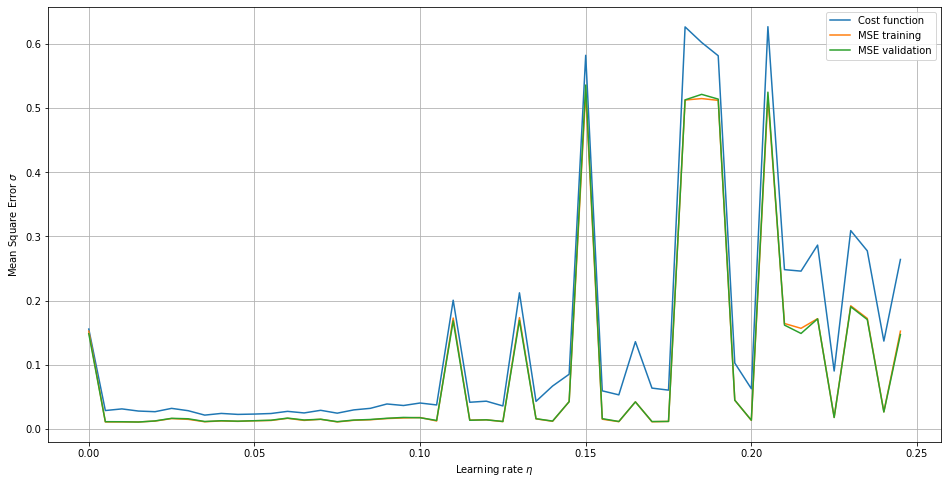

In [119]:
plt.figure(figsize=(16,8))
plt.plot(eta*scalar, mse_optim, label='Cost function')
plt.plot(eta*scalar, mse_train, label='MSE training')
plt.plot(eta*scalar, mse_valid, label='MSE validation')
plt.xlabel('Learning rate $\eta$')
plt.ylabel('Mean Square Error $\sigma$')
plt.legend()
plt.grid()
print('minimum at eta = ', eta*scalar[np.argmin(mse_optim)], 'here mse is', mse_train[np.argmin(mse_optim)])


In [141]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_values, sin_wave, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=(1/3), random_state=42)

sca2 = np.arange(0.01, 20, 0.1)

cost, mtr, mvl = opti(sca2)


18/80 | Cost: 0.37 | Train/Valid MSE.: 0.37/0.37 

5e-05


18/80 | Cost: 0.11 | Train/Valid MSE.: 0.11/0.10 

0.00055


20/80 | Cost: 0.08 | Train/Valid MSE.: 0.07/0.07 

0.0010500000000000002


18/80 | Cost: 0.09 | Train/Valid MSE.: 0.08/0.08 

0.0015500000000000004


20/80 | Cost: 0.05 | Train/Valid MSE.: 0.04/0.04 

0.00205


19/80 | Cost: 0.07 | Train/Valid MSE.: 0.06/0.06 

0.00255


18/80 | Cost: 0.06 | Train/Valid MSE.: 0.05/0.05 

0.0030500000000000006


20/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.0035500000000000006


17/80 | Cost: 0.05 | Train/Valid MSE.: 0.04/0.04 

0.004050000000000001


11/80 | Cost: 0.05 | Train/Valid MSE.: 0.04/0.04 

0.00455


19/80 | Cost: 0.04 | Train/Valid MSE.: 0.03/0.03 

0.00505


19/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.00555


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.006050000000000001


20/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.00655


20/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.007050000000000001


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.00755


20/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.00805


19/80 | Cost: 0.05 | Train/Valid MSE.: 0.03/0.03 

0.00855


19/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.00905


20/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.009550000000000001


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.01005


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.01055


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.01105


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.011550000000000001


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.012050000000000002


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.012549999999999999


19/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.013049999999999999


19/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.01355


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.01405


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.01455


19/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.01505


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.01555


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.016050000000000002


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.016550000000000002


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.017050000000000003


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.01755


18/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.01805


14/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.01855


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.01905


19/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.01955


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.02005


19/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.02 

0.020550000000000002


18/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.02105


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.02155


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.02205


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.02255


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.02305


19/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.02355


18/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.024050000000000002


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.024550000000000002


19/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.02505


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.025550000000000003


19/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.02605


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.026550000000000004


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.02705


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.027549999999999998


15/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.028050000000000002


19/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.02 

0.02855


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.029050000000000003


15/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.02955


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.03005


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.03055


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.03105


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.03155


18/80 | Cost: 0.02 | Train/Valid MSE.: 0.01/0.01 

0.03205


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.03255


16/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.03305


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.03355


12/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.034050000000000004


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.034550000000000004


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.03505


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.035550000000000005


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.03605


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.036550000000000006


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.03705


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.03755


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.03805


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.03855


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.03905


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.03955


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.04005


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.040549999999999996


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.04105


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.041550000000000004


13/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.042050000000000004


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.04255


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.04305


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.043550000000000005


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.044050000000000006


15/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.04455


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.04505


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.04555


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.02 

0.04605000000000001


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.02 

0.04655


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.04705


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.04755


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.04805000000000001


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.04855


16/80 | Cost: 0.04 | Train/Valid MSE.: 0.03/0.03 

0.04905


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.049550000000000004


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.05005


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.050550000000000005


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.051050000000000005


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.051550000000000006


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.02 

0.05205


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.05255


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.05305000000000001


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.05355000000000001


17/80 | Cost: 0.05 | Train/Valid MSE.: 0.03/0.03 

0.05405


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.05455


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.05505


18/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.05555000000000001


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.05605


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.05655


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.02 

0.057050000000000003


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.05755


15/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.058050000000000004


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.058550000000000005


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.059050000000000005


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.05955


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.06005


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.06055000000000001


15/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.06105000000000001


16/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.06155


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.06205


16/80 | Cost: 0.03 | Train/Valid MSE.: 0.02/0.02 

0.06255


14/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.06305000000000001


17/80 | Cost: 0.06 | Train/Valid MSE.: 0.04/0.04 

0.06355000000000001


15/80 | Cost: 0.05 | Train/Valid MSE.: 0.02/0.02 

0.06405000000000001


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.06455


18/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.06505


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.06555000000000001


14/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.02 

0.06605000000000001


14/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.06655


15/80 | Cost: 0.04 | Train/Valid MSE.: 0.01/0.02 

0.06705


17/80 | Cost: 0.05 | Train/Valid MSE.: 0.02/0.02 

0.06755


15/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.06805000000000001


16/80 | Cost: 0.06 | Train/Valid MSE.: 0.04/0.04 

0.06855


18/80 | Cost: 0.04 | Train/Valid MSE.: 0.01/0.01 

0.06905


16/80 | Cost: 0.05 | Train/Valid MSE.: 0.04/0.04 

0.06955


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.07005


16/80 | Cost: 0.05 | Train/Valid MSE.: 0.03/0.03 

0.07055


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.07105


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.02 

0.07155


17/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.07205


17/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.07255


15/80 | Cost: 0.04 | Train/Valid MSE.: 0.01/0.01 

0.07305


13/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.07355


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.07405


18/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.07455


16/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.07505


16/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.07555


17/80 | Cost: 0.05 | Train/Valid MSE.: 0.03/0.03 

0.07605


13/80 | Cost: 0.05 | Train/Valid MSE.: 0.03/0.03 

0.07655


16/80 | Cost: 0.05 | Train/Valid MSE.: 0.03/0.03 

0.07705000000000001


16/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.07755


17/80 | Cost: 0.05 | Train/Valid MSE.: 0.02/0.02 

0.07805000000000001


17/80 | Cost: 0.04 | Train/Valid MSE.: 0.01/0.01 

0.07855000000000001


16/80 | Cost: 0.05 | Train/Valid MSE.: 0.02/0.02 

0.07905000000000001


14/80 | Cost: 0.04 | Train/Valid MSE.: 0.01/0.01 

0.07955


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.08005000000000001


16/80 | Cost: 0.04 | Train/Valid MSE.: 0.01/0.01 

0.08055000000000001


16/80 | Cost: 0.05 | Train/Valid MSE.: 0.02/0.02 

0.08105000000000001


17/80 | Cost: 0.05 | Train/Valid MSE.: 0.03/0.03 

0.08155000000000001


17/80 | Cost: 0.05 | Train/Valid MSE.: 0.03/0.03 

0.08205000000000003


16/80 | Cost: 0.05 | Train/Valid MSE.: 0.02/0.02 

0.08255000000000001


16/80 | Cost: 0.05 | Train/Valid MSE.: 0.02/0.02 

0.08305000000000001


13/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.08355


15/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.08405000000000001


13/80 | Cost: 0.19 | Train/Valid MSE.: 0.17/0.17 

0.08455000000000001


15/80 | Cost: 0.17 | Train/Valid MSE.: 0.15/0.15 

0.08505000000000001


15/80 | Cost: 0.05 | Train/Valid MSE.: 0.02/0.02 

0.08555000000000001


13/80 | Cost: 0.19 | Train/Valid MSE.: 0.17/0.17 

0.08605


16/80 | Cost: 0.06 | Train/Valid MSE.: 0.04/0.04 

0.08655000000000002


16/80 | Cost: 0.04 | Train/Valid MSE.: 0.01/0.01 

0.08705000000000002


15/80 | Cost: 0.05 | Train/Valid MSE.: 0.02/0.02 

0.08755


14/80 | Cost: 0.06 | Train/Valid MSE.: 0.04/0.04 

0.08805000000000002


16/80 | Cost: 0.05 | Train/Valid MSE.: 0.03/0.03 

0.08855


15/80 | Cost: 0.09 | Train/Valid MSE.: 0.06/0.06 

0.08905000000000002


17/80 | Cost: 0.05 | Train/Valid MSE.: 0.03/0.03 

0.08955000000000002


15/80 | Cost: 0.06 | Train/Valid MSE.: 0.04/0.04 

0.09005


16/80 | Cost: 0.05 | Train/Valid MSE.: 0.03/0.03 

0.09055000000000002


18/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.09105


17/80 | Cost: 0.07 | Train/Valid MSE.: 0.05/0.05 

0.09155


15/80 | Cost: 0.05 | Train/Valid MSE.: 0.03/0.03 

0.09205000000000002


16/80 | Cost: 0.08 | Train/Valid MSE.: 0.05/0.05 

0.09255000000000001


17/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

0.09305000000000002


15/80 | Cost: 0.08 | Train/Valid MSE.: 0.05/0.05 

0.09355000000000001


16/80 | Cost: 0.04 | Train/Valid MSE.: 0.01/0.01 

0.09405000000000001


15/80 | Cost: 0.08 | Train/Valid MSE.: 0.04/0.05 

0.09455000000000002


15/80 | Cost: 0.07 | Train/Valid MSE.: 0.04/0.04 

0.09505000000000001


16/80 | Cost: 0.08 | Train/Valid MSE.: 0.06/0.06 

0.09555000000000002


16/80 | Cost: 0.04 | Train/Valid MSE.: 0.01/0.01 

0.09605000000000002


17/80 | Cost: 0.04 | Train/Valid MSE.: 0.01/0.01 

0.09655000000000001


15/80 | Cost: 0.06 | Train/Valid MSE.: 0.03/0.03 

0.09705000000000003


15/80 | Cost: 0.06 | Train/Valid MSE.: 0.03/0.03 

0.09755000000000001


18/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.09805000000000001


17/80 | Cost: 0.05 | Train/Valid MSE.: 0.02/0.02 

0.09855000000000003


16/80 | Cost: 0.04 | Train/Valid MSE.: 0.02/0.02 

0.09905000000000001


16/80 | Cost: 0.05 | Train/Valid MSE.: 0.02/0.02 

0.09955000000000003


80/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

In [133]:
print(len(sca2*eta))

200


minimum at eta =  0.00455 here mse is 0.010341503137681719
minimum at eta =  0.00455 here mse is 0.010621561160841253


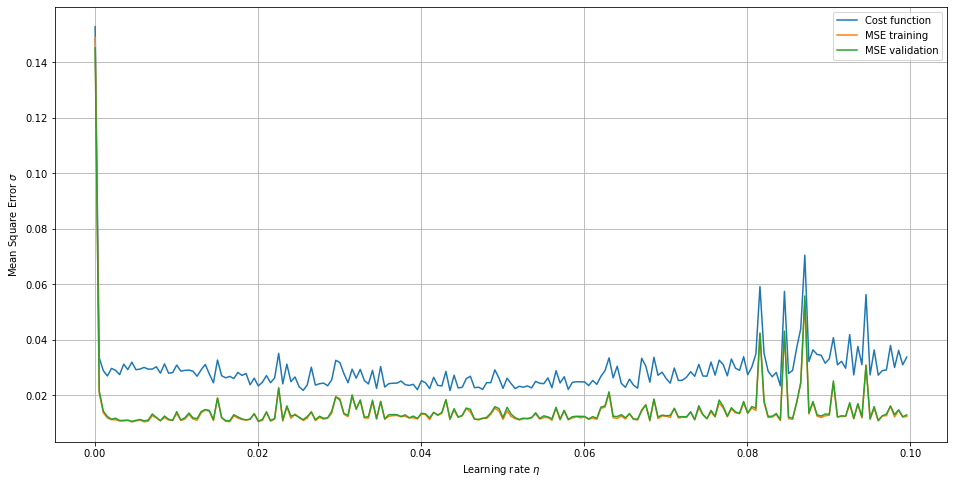

In [142]:

plt.figure(figsize=(16,8))
plt.plot(eta*sca2, cost, label='Cost function')
plt.plot(eta*sca2, mtr, label='MSE training')
plt.plot(eta*sca2, mvl, label='MSE validation')
plt.xlabel('Learning rate $\eta$')
plt.ylabel('Mean Square Error $\sigma$')
plt.legend()
plt.grid()
print('minimum at eta = ', eta*sca2[np.argmin(mtr)], 'here mse is', mtr[np.argmin(mtr)])
print('minimum at eta = ', eta*sca2[np.argmin(mvl)], 'here mse is', mvl[np.argmin(mvl)])

    

In [122]:
print(np.argmin(cost))#COST
print(np.argmin(mtr))#MSE TRAIN
print(np.argmin(mvl))#MSE VALID

75
16
36


In [143]:
mlpopt = MLP(eta=0.00455)
mlpopt.train(X_train, y_train, X_val, y_val)

80/80 | Cost: 0.03 | Train/Valid MSE.: 0.01/0.01 

In [144]:
mlpopt.evaluate(X_test, y_test)

mean squared error:0.010698873667357505


In [145]:
pred = mlpopt.predict(X_test)

In [146]:
def sin(x):
    return np.sin(x)

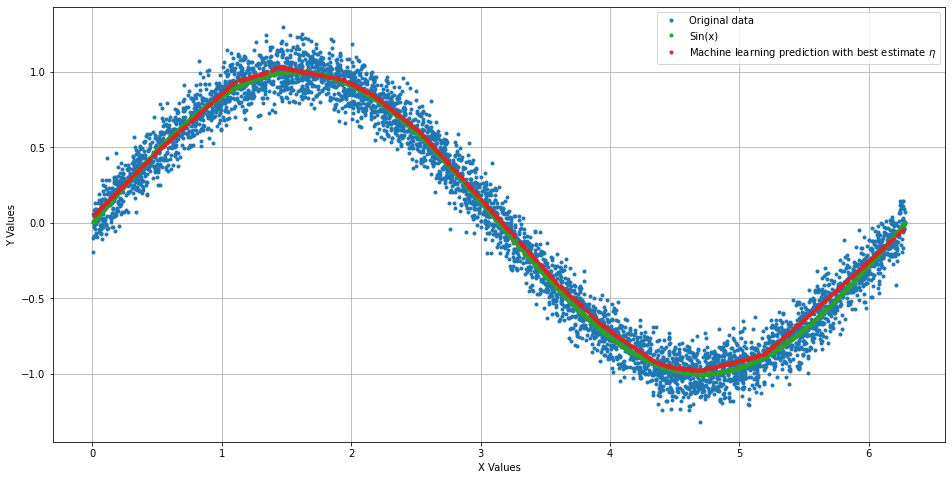

In [151]:
plt.figure(figsize=(16,8))
plt.plot(x_values,sin_wave,'.', label='Original data')
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.plot(x_values, sin(x_values), '.', label='Sin(x)', c='tab:green')
plt.plot(X_test, pred, '.', c='tab:red', markersize=6, label='Machine learning prediction with best estimate $\eta$')
plt.legend()
plt.grid()

In [148]:
from sklearn.metrics import r2_score

# assuming you have test data in variables X_test and y_test
y_pred = mlpopt.predict(X_test)  # mlp is an instance of your MLP class
r2 = r2_score(y_test, y_pred)

print(f'R-squared: {r2:.4f}')


R-squared: 0.9793
